# Setup

In [6]:
import os
import numpy as np
import matplotlib.pylab as plt
import cv2
from google.colab.patches import cv2_imshow

In [2]:
# setup OpenImageIO
!if ! [ -f "oiio-2.0.5-cp37-none-linux_x86_64.whl" ]; then wget https://github.com/fredrikaverpil/oiio-python/releases/download/2.0.5%2B20190203/oiio-2.0.5-cp37-none-linux_x86_64.whl; fi
!pip install oiio-2.0.5-cp37-none-linux_x86_64.whl

from oiio import OpenImageIO as oiio


Processing ./oiio-2.0.5-cp37-none-linux_x86_64.whl
oiio is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [7]:
# Dark mode matplotlib style
plt.rcParams.update({
    "lines.color": "gray",
    "lines.linewidth": 0.5,
    "patch.edgecolor": "gray",
    "text.color": "lightgray",
    "axes.facecolor": "#333",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "lightgray",
    "xtick.color": "lightgray",
    "ytick.color": "lightgray",
    "grid.color": "#222",
    "markers.fillstyle": 'none',
    "figure.facecolor": "#222",
    "figure.edgecolor": "#333",
    "savefig.facecolor": "#333",
    "savefig.edgecolor": "#333"})
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["figure.dpi"] = 100

np.seterr(all='ignore', divide='ignore', over='ignore', under='ignore', invalid='ignore')


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# Fetch Images

In [8]:

!if ! [ -d 'images' ]; then git clone https://github.com/gralk/images.git; fi
images = ['images/exr/'+f for f in os.listdir('images/exr') if f.endswith('.exr')]
images.sort()
print(images)

arri_images = [f for f in images if 'arri' in f]
cml_images = [f for f in images if 'cinematography-mailing-list' in f]
red_images = [f for f in images if 'red' in f]
hdm_images = [f for f in images if 'hdm-vmlab' in f]
vwg_images = [f for f in images if 'vwg' in f]


['images/exr/SRIC_arri.01001.exr', 'images/exr/SRIC_arri.01002.exr', 'images/exr/SRIC_arri.01003.exr', 'images/exr/SRIC_arri.01004.exr', 'images/exr/SRIC_arri.01005.exr', 'images/exr/SRIC_arri.01006.exr', 'images/exr/SRIC_arri.01007.exr', 'images/exr/SRIC_arri.01008.exr', 'images/exr/SRIC_arri.01009.exr', 'images/exr/SRIC_arri.01010.exr', 'images/exr/SRIC_arri.01011.exr', 'images/exr/SRIC_arri.01012.exr', 'images/exr/SRIC_arri.01013.exr', 'images/exr/SRIC_arri.01014.exr', 'images/exr/SRIC_arri.01015.exr', 'images/exr/SRIC_arri.01016.exr', 'images/exr/SRIC_arri.01017.exr', 'images/exr/SRIC_arri.01018.exr', 'images/exr/SRIC_arri.01019.exr', 'images/exr/SRIC_cinematography-mailing-list.01001.exr', 'images/exr/SRIC_cinematography-mailing-list.01002.exr', 'images/exr/SRIC_cinematography-mailing-list.01003.exr', 'images/exr/SRIC_cinematography-mailing-list.01004.exr', 'images/exr/SRIC_cinematography-mailing-list.01005.exr', 'images/exr/SRIC_cinematography-mailing-list.01006.exr', 'images/exr

# Display Rendering Transform

In [4]:
def mult_f3_f33(v, m, invert=False):
  # multiply 1x3 vector with 3x3 matrix
  # expects a (height, width, channels) shape
  if invert:
    m = np.linalg.inv(m)
  if np.size(v, 2) > 3: # remove alpha
    v = v[:, :, :3]
  return np.einsum("...ij,...j->...i", m, v)


# Matrices
mtx_egamut_to_XYZ = [[0.70539683, 0.16404134, 0.08101775],
                     [0.28013071, 0.82020670, -0.10033738],
                     [-0.10378151, -0.07290726, 1.26574659]]
mtx_rec709_to_XYZ = [[0.41239092, 0.35758436, 0.18048079],
                     [0.21263908, 0.71516871, 0.07219231],
                     [0.01933083, 0.11919478, 0.95053214]]
mtx_rgbdt_to_XYZ = [[0.72113842, 0.11148937, 0.11782813],
                    [0.22163042, 0.91144598, -0.13307647],
                    [-0.10325963, -0.20914429, 1.40146172]]
mtx_desat_10p = [[0.921264, 0.0715169, 0.00721923],
                [0.0212639, 0.971517, 0.00721923], 
                [0.0212639, 0.0715169, 0.907219]]

# tonescale for Rec.709
def tonescale(rgb):
  # params
  c0 = 1.2
  cs = 0.18**(1.0-c0)
  s0 = 1.22265899
  s1 = 1.04547374
  p = 1.05
  fl = 0.01
  # pre-tonemap contrast
  rgb = np.where(rgb < 0.18, cs*np.power(rgb, c0), c0*(rgb-0.18)+0.18)
  # tonemap
  rgb = s1*np.power(rgb/(rgb+s0), p)
  # flare
  rgb = np.power(rgb, 2)/(rgb+fl)
  return rgb

# apply simple per-channel display rendering transform
def rgb_display_transform(img):
  img = mult_f3_f33(img, mtx_egamut_to_XYZ)
  img = mult_f3_f33(img, mtx_rgbdt_to_XYZ, invert=True)
  img = np.clip(0.0, 65535.0, img)
  img = tonescale(img)
  img = mult_f3_f33(img, mtx_rgbdt_to_XYZ)
  img = mult_f3_f33(img, np.linalg.inv(mtx_rec709_to_XYZ))
  img = mult_f3_f33(img, mtx_desat_10p)
  img = np.clip(0.0, 1.0, img)
  img = np.power(img, 1/2.4)
  # convert to uint8 and return
  img *= 255
  img = img.astype(np.uint8)
  return img


# Plot Images

In [ ]:
# def plt_img(img):
#   # plot image using matplotlib
#   plt.gca().set_axis_off()
#   plt.imshow(img)
#   plt.show()

# for image in images:
#   print(image)
#   img = oiio.ImageInput.open(image).read_image(format='float')
#   img = rgb_display_transform(img)
#   plt_img(img)

images/exr/SRIC_cinematography-mailing-list.01001.exr


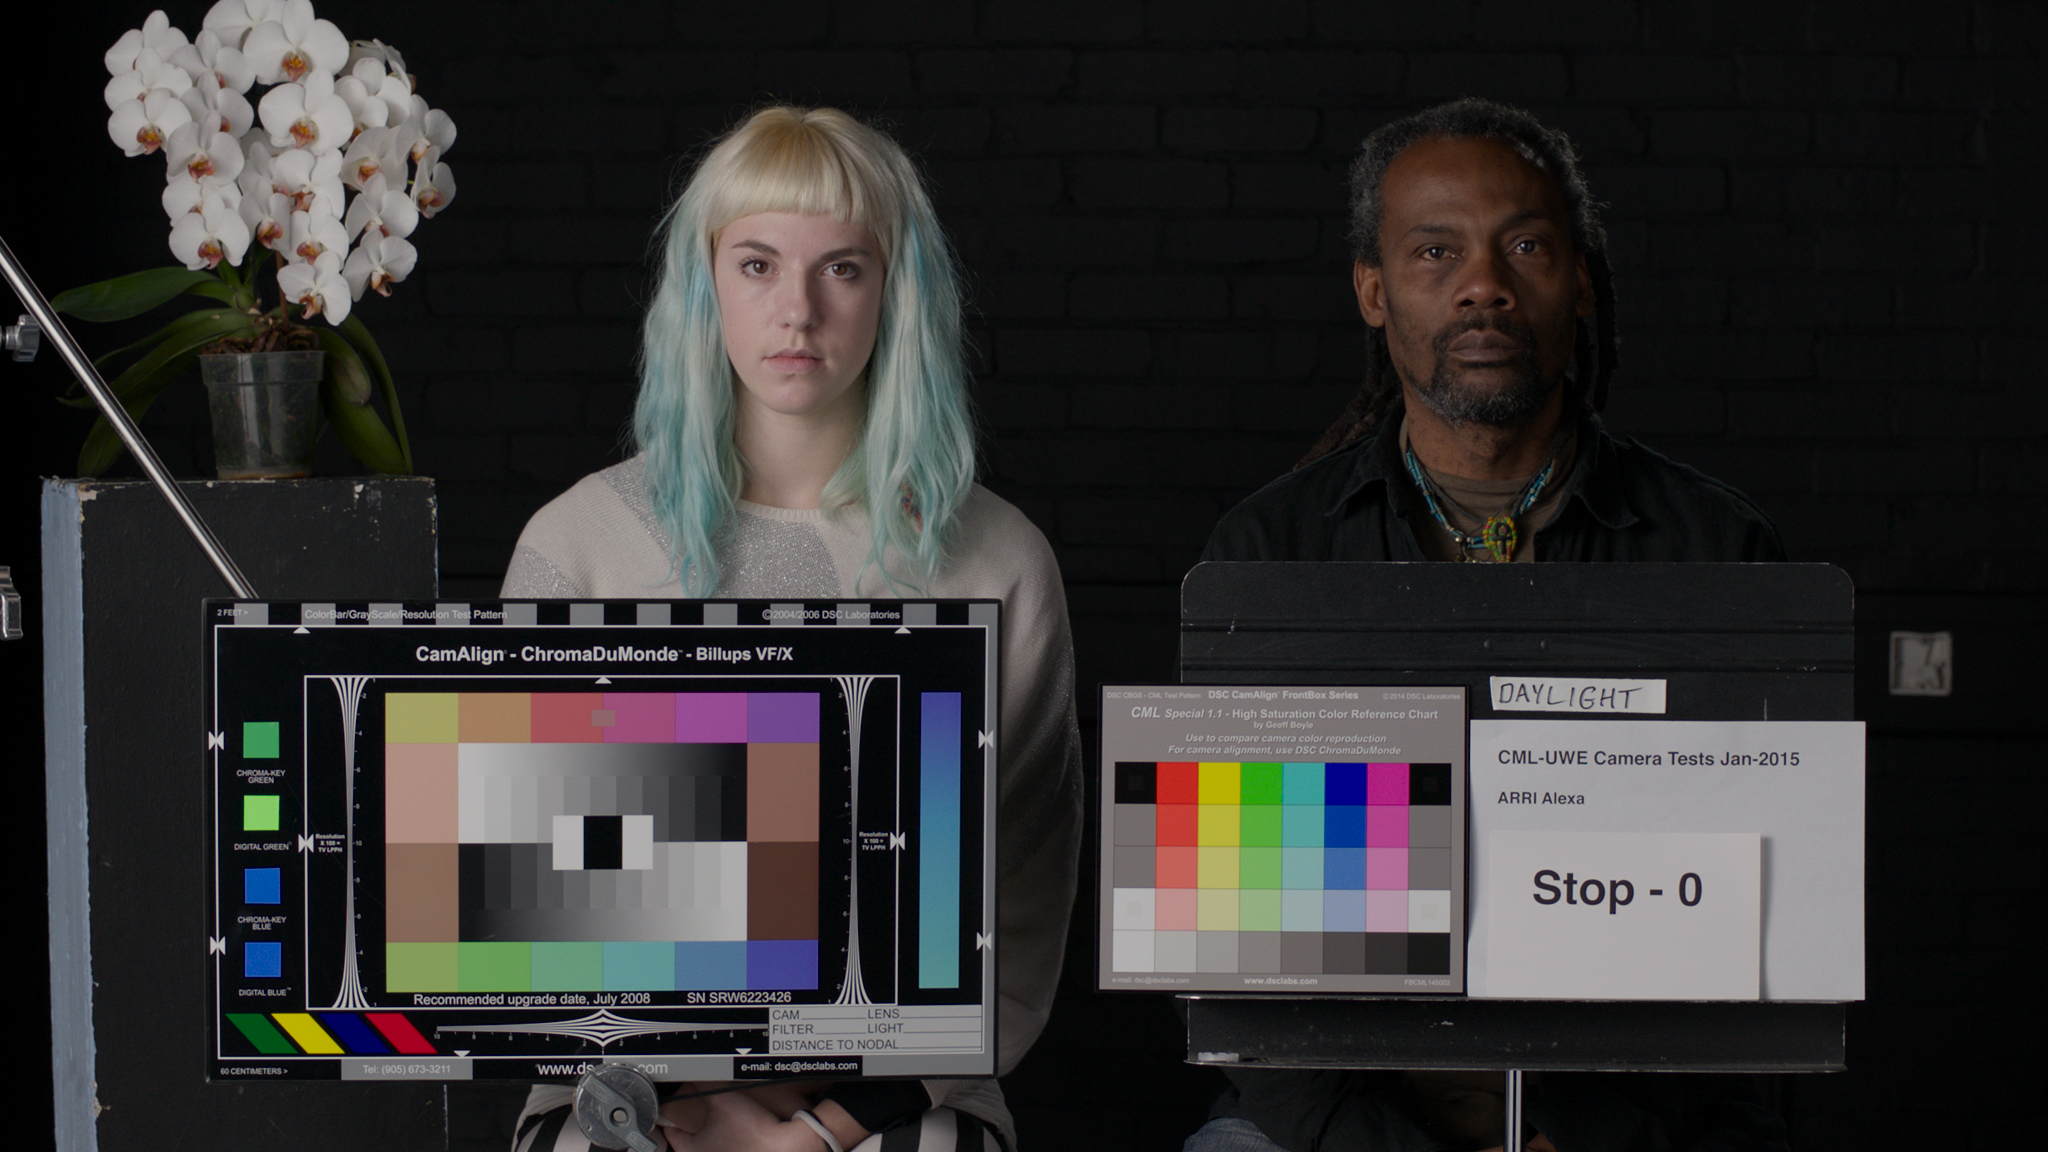

images/exr/SRIC_vwg_output-transforms.01014.exr


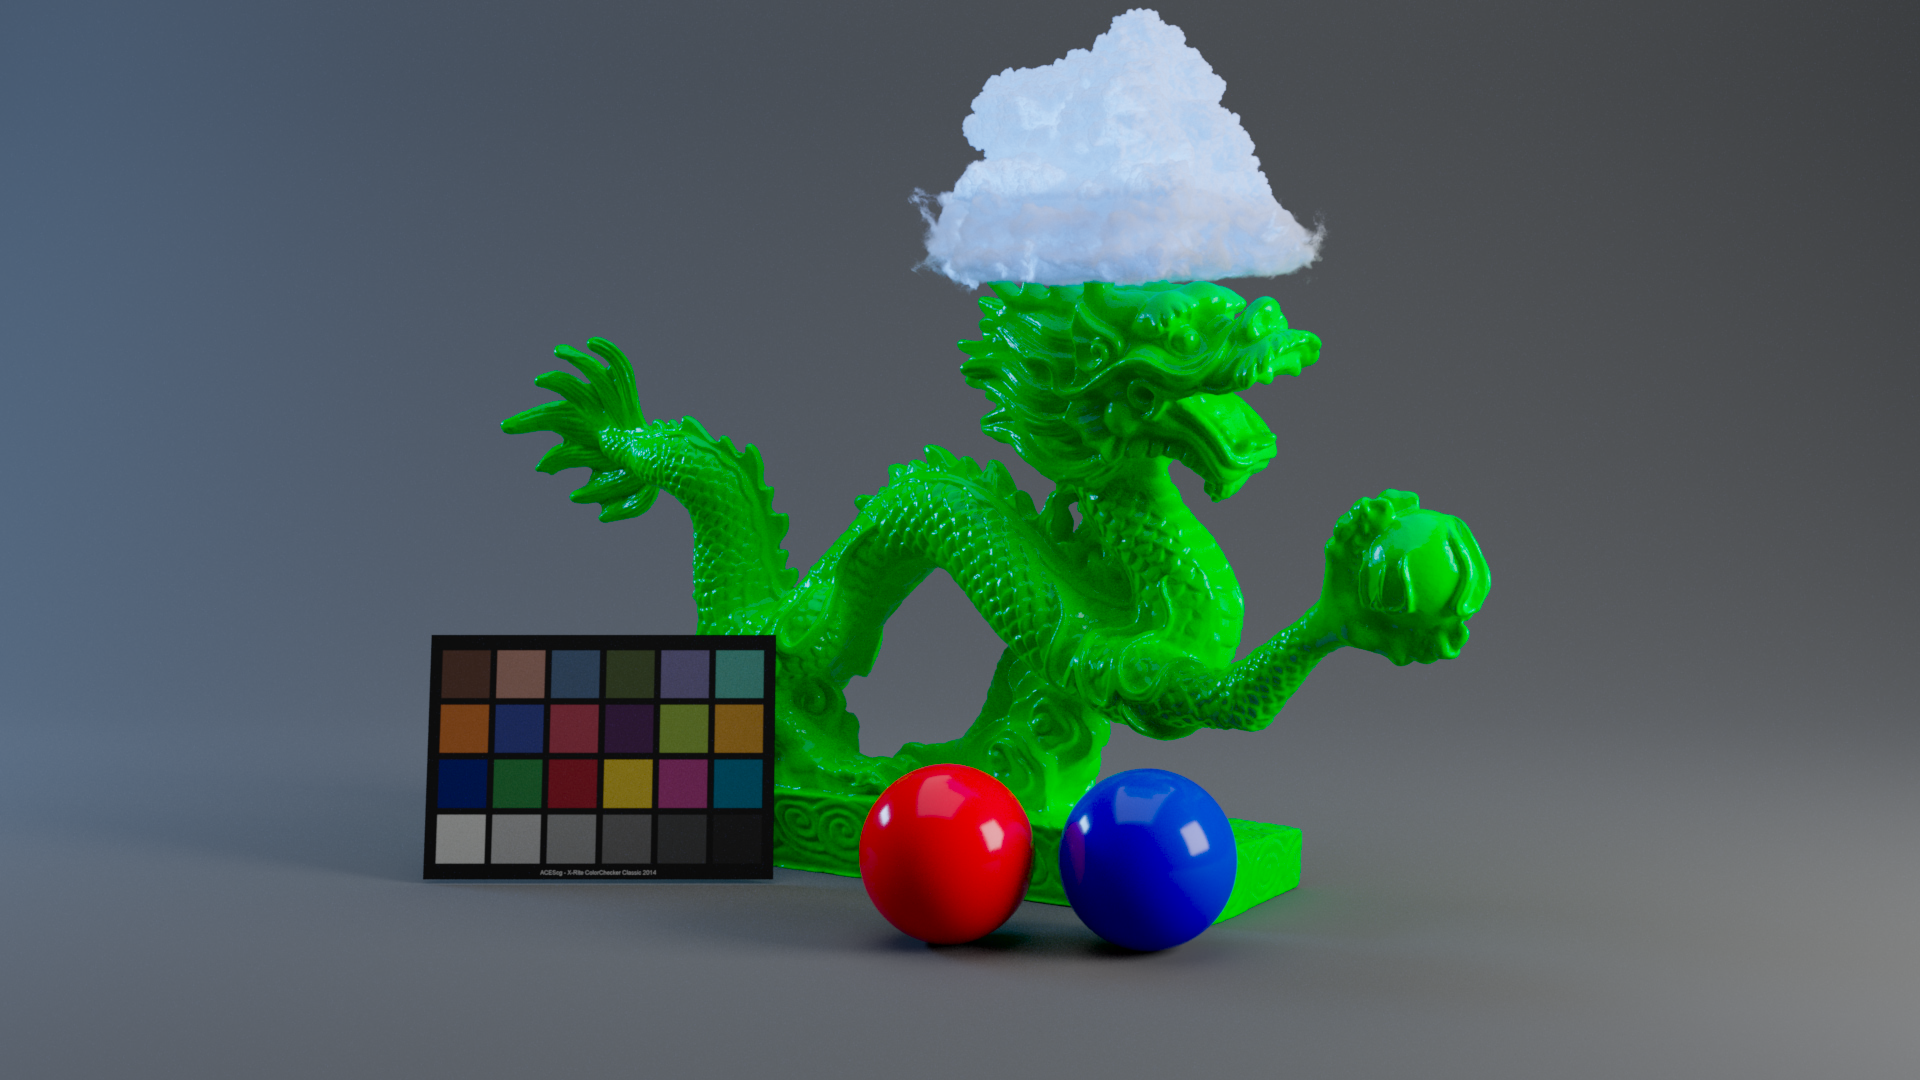

In [9]:
def plot_img_cv2(img):
  # plot image with cv2_imshow. expects BGR not RGB so we have to switch the channels
  cv2_imshow(cv2.merge([img[:,:,2], img[:,:,1], img[:,:,0]]))

image_selects = [
                 'images/exr/SRIC_cinematography-mailing-list.01001.exr', 
                 'images/exr/SRIC_vwg_output-transforms.01014.exr',
]
for image in image_selects:
    print(image)
    img = oiio.ImageInput.open(image).read_image()
    img = rgb_display_transform(img)
    plot_img_cv2(img)
